# Find precipitation value for pulsed and upslope storms and create seasonal statistic

In [7]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')

import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')



In [8]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

In [9]:
savefig = 0
if savefig == 1:
    figdir = '../../Figures/Weathermast_MEPS_Retrieval/%s/precip_seasonal_stat' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

In [10]:
year = '2016'
month = '11'
day = '09'

In [11]:
f = dict()
obs_precip_diff      = dict()
obs_precip_diff_2deg = dict()
obs_west_idx         = dict()
obs_east_idx         = dict()
obs_precip_total     = dict()
obs_precip_west      = dict()
obs_precip_east      = dict()
obs_precip_total_2deg= dict()
obs_precip_west_2deg = dict()
obs_precip_east_2deg = dict()
    
meps_precip_diff     = dict()
meps_precip_diff_2deg= dict()
meps_west_idx        = dict()
meps_east_idx        = dict()
meps_precip_total    = dict()
meps_precip_west     = dict()
meps_precip_east     = dict()
meps_precip_total_2deg= dict()
meps_precip_west_2deg = dict()
meps_precip_east_2deg = dict()
    
ret_precip_diff      = dict()
ret_precip_total     = dict()
ret_precip_west      = dict()
ret_precip_east      = dict()


for month in m:
    if month == '11':
#        t = np.arange(8,31)
        t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
    if month == '12': #or  or 
 #       t = np.arange(1,32)
        t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
    if month == '01':
        t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
    if month == '02':
  #      t = np.arange(1,29)
        t = [2, 3, 4, 6]
    if month == '03':
        t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)
        nc_dir = '../../Data/Weathermast_MEPS_Retrieval/'+station+'/weathermast_meps_retrieval_%s.nc' %(Date)

        f[Date] = netCDF4.Dataset(nc_dir, 'r')

        obs_precip_diff[Date]      = f[Date].variables['obs_precipitation_difference'][:]
        obs_precip_diff_2deg[Date] = f[Date].variables['obs_precipitation_difference_2degC'][:]
        obs_west_idx[Date]         = f[Date].variables['obs_idx_westerly'][:].astype(int)
        obs_east_idx[Date]         = f[Date].variables['obs_idx_easterly'][:].astype(int)

        meps_precip_diff[Date]     = f[Date].variables['meps_precipitation_difference'][:]
        meps_precip_diff_2deg[Date]= f[Date].variables['meps_precipitation_difference_2degC'][:]
        meps_west_idx[Date]        = f[Date].variables['meps_idx_westerly'][:]
        meps_east_idx[Date]        = f[Date].variables['meps_idx_easterly'][:]

        ret_precip_diff[Date]      = f[Date].variables['ret_precipitation_difference'][:]

        f[Date].close()

        ############################################
        if len(obs_west_idx[Date]) == 0 and len(obs_east_idx[Date]) == 0:
            obs_precip_total[Date] = np.nan
            obs_precip_west[Date]  = np.nan
            obs_precip_east[Date]  = np.nan
        ### observation == reference
        obs_precip_total[Date] = np.nansum(obs_precip_diff[Date][obs_west_idx[Date],]) + \
                                 np.nansum(obs_precip_diff[Date][obs_east_idx[Date],])
        obs_precip_west[Date]  = np.nansum(obs_precip_diff[Date][obs_west_idx[Date],])
        obs_precip_east[Date]  = np.nansum(obs_precip_diff[Date][obs_east_idx[Date],])
        ### retrieval
        ret_precip_total[Date] = np.nansum(ret_precip_diff[Date][obs_west_idx[Date],]) + \
                                 np.nansum(ret_precip_diff[Date][obs_east_idx[Date],])
        ret_precip_west[Date]  = np.nansum(ret_precip_diff[Date][obs_west_idx[Date],])
        ret_precip_east[Date]  = np.nansum(ret_precip_diff[Date][obs_east_idx[Date],])
        ### MEPS
        meps_precip_total[Date] = []
        meps_precip_west[Date]  = []
        meps_precip_east[Date]  = []
        for ens_memb in range(10):
            total = np.nansum(meps_precip_diff[Date][np.where(~np.isnan(meps_west_idx[Date][:,ens_memb])), ens_memb]) + \
                    np.nansum(meps_precip_diff[Date][np.where(~np.isnan(meps_east_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_total[Date].append(total)

            westerly = np.nansum(meps_precip_diff[Date][np.where(~np.isnan(meps_west_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_west[Date].append(westerly)

            easterly = np.nansum(meps_precip_diff[Date][np.where(~np.isnan(meps_east_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_east[Date].append(easterly)

            del total, westerly, easterly

        ## for precipitation below 2degC
        ### observation
        obs_precip_total_2deg[Date] = np.nansum(obs_precip_diff_2deg[Date][obs_west_idx[Date],]) + \
                                      np.nansum(obs_precip_diff_2deg[Date][obs_east_idx[Date],])
        obs_precip_west_2deg[Date]  = np.nansum(obs_precip_diff_2deg[Date][obs_west_idx[Date],])
        obs_precip_east_2deg[Date]  = np.nansum(obs_precip_diff_2deg[Date][obs_east_idx[Date],])
        ### MEPS
        meps_precip_total_2deg[Date] = []
        meps_precip_west_2deg[Date]  = []
        meps_precip_east_2deg[Date]  = []
        for ens_memb in range(10):
            total = np.nansum(meps_precip_diff_2deg[Date][np.where(~np.isnan(meps_west_idx[Date][:,ens_memb])), ens_memb]) + \
                    np.nansum(meps_precip_diff_2deg[Date][np.where(~np.isnan(meps_east_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_total_2deg[Date].append(total)

            westerly = np.nansum(meps_precip_diff_2deg[Date][np.where(~np.isnan(meps_west_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_west_2deg[Date].append(westerly)

            easterly = np.nansum(meps_precip_diff_2deg[Date][np.where(~np.isnan(meps_east_idx[Date][:,ens_memb])), ens_memb])
            meps_precip_east_2deg[Date].append(easterly)

            del total, westerly, easterly
            


In [12]:
############################

In [14]:
# calculate monthly precip sum observation for <2degC, and valid days
obs_total_2deg = []
obs_total_east_2deg = []
obs_total_west_2deg = []



for month in m:
    if month == '11':
#        t = np.arange(8,31)
        t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
    if month == '12': #or  or 
 #       t = np.arange(1,32)
        t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
    if month == '01':
        t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
    if month == '02':
  #      t = np.arange(1,29)
        t = [2, 3, 4, 6]
    if month == '03':
        t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
      
    obs_monthly_sum_2deg = 0.0
    obs_monthly_east_sum_2deg = 0.0
    obs_monthly_west_sum_2deg = 0.0

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        tot_val_2deg = (obs_precip_total_2deg[int(year+month+day)])
        obs_monthly_sum_2deg = np.sum([obs_monthly_sum_2deg,tot_val_2deg])
        
        east_val_2deg = (obs_precip_east_2deg[int(year+month+day)])
        obs_monthly_east_sum_2deg = np.sum([obs_monthly_east_sum_2deg, east_val_2deg])
        
        west_val_2deg = (obs_precip_west_2deg[int(year+month+day)])
        obs_monthly_west_sum_2deg = np.sum([obs_monthly_west_sum_2deg, west_val_2deg])
        
        if int(day) == t[-1]:
            obs_total_2deg.append(obs_monthly_sum_2deg)
            obs_total_east_2deg.append(obs_monthly_east_sum_2deg)
            obs_total_west_2deg.append(obs_monthly_west_sum_2deg)
            
    print(int(year+month+day), 'total:', np.round(obs_monthly_sum_2deg,2),
                               'west:',  np.round(obs_monthly_west_sum_2deg,2),
                               'east:',  np.round(obs_monthly_east_sum_2deg,2))
#print('total:', np.round(sum(obs_total_precip.values()),2), 
 #     'east:', np.round(sum(obs_precip_east.values()),2), 
  #    'west:', np.round(sum(obs_precip_west.values()),2))

print('total:', np.round(np.sum(obs_total_2deg),2),
      'west:',  np.round(np.sum(obs_total_west_2deg), 2),
      'east:',  np.round(np.sum(obs_total_east_2deg), 2))

20161130 total: 42.5 west: 24.67 east: 17.83
20161231 total: 138.97 west: 116.53 east: 22.45
20170129 total: 87.09 west: 48.82 east: 38.27
20170206 total: 16.62 west: 0.37 east: 16.25
20170331 total: 83.95 west: 60.51 east: 23.44
total: 369.14 west: 250.9 east: 118.25


### RETRIEVAL

In [ ]:
### MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [15]:
# calculate monthly precip sum for retrieved precipitation
ret_total = []
ret_total_east = []
ret_total_west = []


for month in m:
    if month == '11':
#        t = np.arange(8,31)
        t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
    if month == '12': #or  or 
 #       t = np.arange(1,32)
        t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
    if month == '01':
        t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
    if month == '02':
  #      t = np.arange(1,29)
        t = [2, 3, 4, 6]
    if month == '03':
        t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    ret_monthly_sum = 0.0
    ret_monthly_east_sum = 0.0
    ret_monthly_west_sum = 0.0

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        tot_val = (ret_precip_total[int(year+month+day)])
        ret_monthly_sum = np.sum([ret_monthly_sum,tot_val])
        
        east_val = (ret_precip_east[int(year+month+day)])
        ret_monthly_east_sum = np.sum([ret_monthly_east_sum, east_val])
        
        west_val = (ret_precip_west[int(year+month+day)])
        ret_monthly_west_sum = np.sum([ret_monthly_west_sum, west_val])
        
        if int(day) == t[-1]:
            ret_total.append(ret_monthly_sum)
            ret_total_east.append(ret_monthly_east_sum)
            ret_total_west.append(ret_monthly_west_sum)
            
    print(int(year+month+day), 'total:', np.round(ret_monthly_sum,2),
                               'east:',  np.round(ret_monthly_east_sum,2),
                               'west:',  np.round(ret_monthly_west_sum,2))
#print('total:', np.round(sum(ret_precip_total.values()),2), 
 #     'east:', np.round(sum(ret_precip_east.values()),2), 
  #    'west:', np.round(sum(ret_precip_west.values()),2))

ret_sum = np.sum(ret_total,axis=0)
ret_east_sum = np.sum(ret_total_east, axis=0)
ret_west_sum = np.sum(ret_total_west, axis=0)

print('total:', np.round(np.sum(ret_total),2),
      'east:',  np.round(np.sum(ret_total_east), 2),
      'west:',  np.round(np.sum(ret_total_west), 2))

20161130 total: 42.63 east: 20.34 west: 22.29
20161231 total: 150.09 east: 22.94 west: 127.16
20170129 total: 89.9 east: 49.15 west: 40.75
20170206 total: 20.84 east: 20.74 west: 0.1
20170331 total: 90.4 east: 23.44 west: 66.96
total: 393.85 east: 136.61 west: 257.24


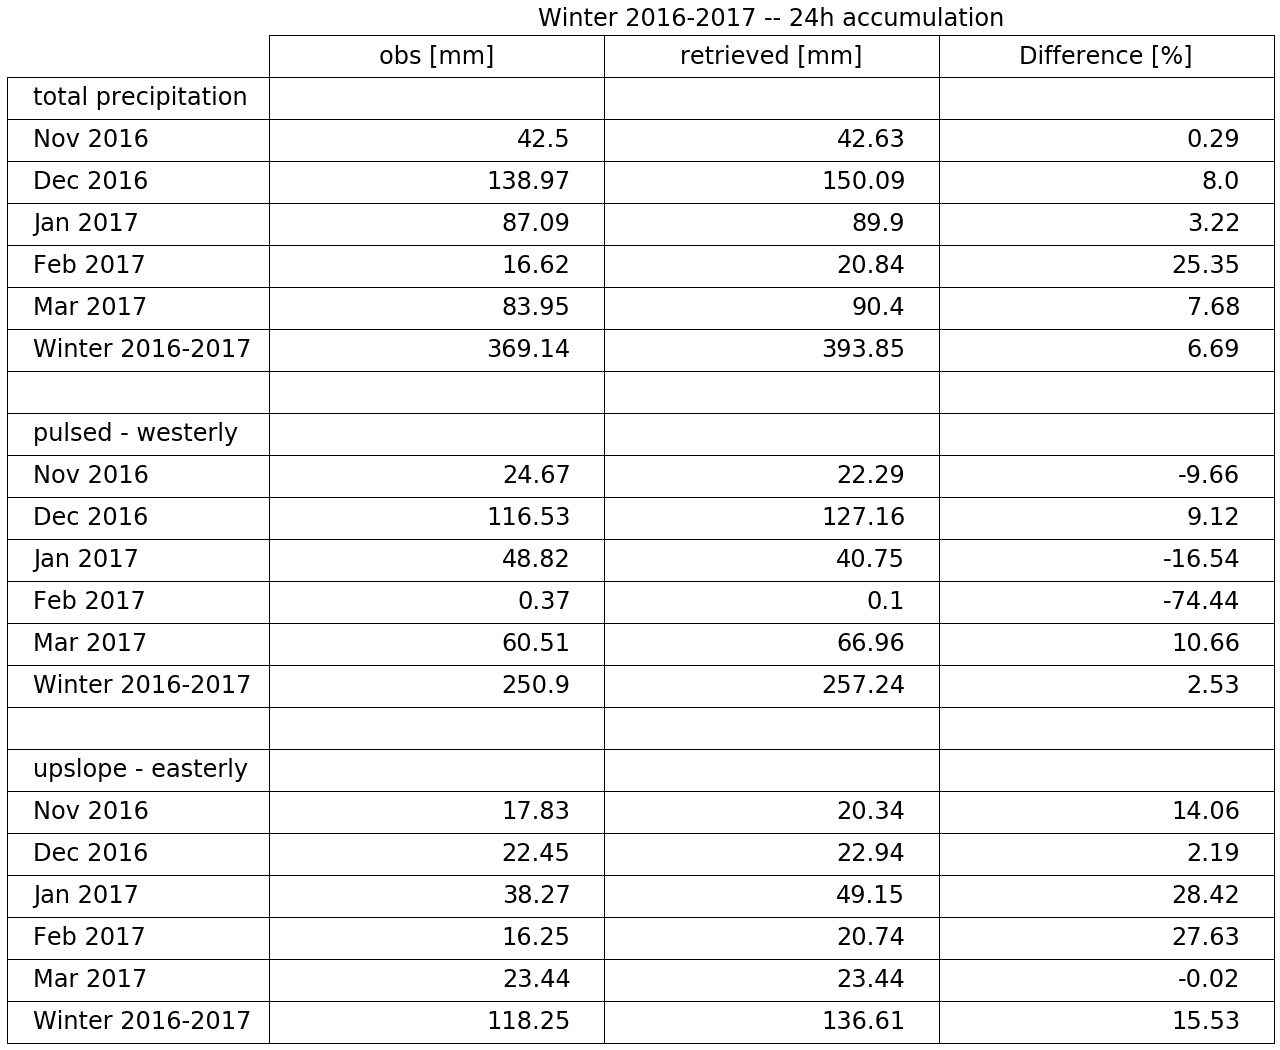

In [16]:
### retrieval seasonal statistics
diff_perc_monthly = np.zeros(shape=np.array(ret_total).shape)
diff_perc_season = np.zeros(shape=ret_sum.shape)

diff_perc_monthly_east = np.zeros(shape=np.array(ret_total_east).shape)
diff_perc_season_east = np.zeros(shape=ret_east_sum.shape)

diff_perc_monthly_west = np.zeros(shape=np.array(ret_total_west).shape)
diff_perc_season_west = np.zeros(shape=ret_west_sum.shape)

diff_perc_monthly = (ret_total - np.array(obs_total_2deg))/np.array(obs_total_2deg)*100
diff_perc_season  = (np.sum(ret_total) - np.sum(obs_total_2deg))/np.sum(obs_total_2deg)*100
    
diff_perc_monthly_east = (ret_total_east - np.array(obs_total_east_2deg))/np.array(obs_total_east_2deg)*100
diff_perc_season_east  = (ret_east_sum - np.sum(obs_total_east_2deg))/np.sum(obs_total_east_2deg)*100
    
diff_perc_monthly_west = (ret_total_west - np.array(obs_total_west_2deg))/np.array(obs_total_west_2deg)*100
diff_perc_season_west = (ret_west_sum - np.sum(obs_total_west_2deg))/np.sum(obs_total_west_2deg)*100

### create table

col_labels = ['obs [mm]', 'retrieved [mm]','Difference [%]', ]
row_labels = ['total precipitation', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '', 
              'pulsed - westerly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '',
              'upslope - easterly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017']
#for  in range(10):

table_vals = [ ['', '' , '' ],
               [np.round(obs_total_2deg[0],2), np.round(ret_total[0],2), np.round(diff_perc_monthly[0],2)],
               [np.round(obs_total_2deg[1],2), np.round(ret_total[1],2), np.round(diff_perc_monthly[1],2)],
               [np.round(obs_total_2deg[2],2), np.round(ret_total[2],2), np.round(diff_perc_monthly[2],2)],
               [np.round(obs_total_2deg[3],2), np.round(ret_total[3],2), np.round(diff_perc_monthly[3],2)],
               [np.round(obs_total_2deg[4],2), np.round(ret_total[4],2), np.round(diff_perc_monthly[4],2)],
               [np.round(np.sum(obs_total_2deg),2), np.round(ret_sum,2), np.round(diff_perc_season,2)],
               ['', '', ''],
               ['', '', '' ],
               [np.round(obs_total_west_2deg[0],2), np.round(ret_total_west[0],2), np.round(diff_perc_monthly_west[0],2)],
               [np.round(obs_total_west_2deg[1],2), np.round(ret_total_west[1],2), np.round(diff_perc_monthly_west[1],2)],
               [np.round(obs_total_west_2deg[2],2), np.round(ret_total_west[2],2), np.round(diff_perc_monthly_west[2],2)],
               [np.round(obs_total_west_2deg[3],2), np.round(ret_total_west[3],2), np.round(diff_perc_monthly_west[3],2)],
               [np.round(obs_total_west_2deg[4],2), np.round(ret_total_west[4],2), np.round(diff_perc_monthly_west[4],2)],
               [np.round(np.sum(obs_total_west_2deg),2), np.round(ret_west_sum,2), np.round(diff_perc_season_west,2)],
               ['', '', ''],
               ['', '', '' ],
               [np.round(obs_total_east_2deg[0],2), np.round(ret_total_east[0],2), np.round(diff_perc_monthly_east[0],2)],
               [np.round(obs_total_east_2deg[1],2), np.round(ret_total_east[1],2), np.round(diff_perc_monthly_east[1],2)],
               [np.round(obs_total_east_2deg[2],2), np.round(ret_total_east[2],2), np.round(diff_perc_monthly_east[2],2)],
               [np.round(obs_total_east_2deg[3],2), np.round(ret_total_east[3],2), np.round(diff_perc_monthly_east[3],2)],
               [np.round(obs_total_east_2deg[4],2), np.round(ret_total_east[4],2), np.round(diff_perc_monthly_east[4],2)],
               [np.round(np.sum(obs_total_east_2deg),2), np.round(ret_east_sum,2), np.round(diff_perc_season_east,2)]]


# Draw table
fig = plt.figure()
ax = fig.add_subplot(111)
the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    
yy = 2.83
fig_name = station+'_winter_16_17_retrieval_2degC'+'.'+form
ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
else:
        plt.show()
plt.close()
    
    

### MEPS

In [20]:
# calculate monthly precip sum observation for <2degC, and valid days

meps_sum_2deg = 0.0
meps_east_sum_2deg = 0.0
meps_west_sum_2deg = 0.0
meps_total_2deg = []
meps_total_east_2deg = []
meps_total_west_2deg = []

for month in m:
    if month == '11':
#        t = np.arange(8,31)
        t = [9, 12, 13, 14, 15, 16, 17, 23, 24, 26,29,30]
    if month == '12': #or  or 
 #       t = np.arange(1,32)
        t = [7, 9, 10, 11, 12, 13, 15, 21, 22, 23, 24, 25, 26, 29, 30, 31]
    if month == '01':
        t = [2, 3, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 28, 29]
    if month == '02':
  #      t = np.arange(1,29)
        t = [2, 3, 4, 6]
    if month == '03':
        t = [9, 14, 16, 17, 19, 21, 24, 30, 31]
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for ens_memb in np.arange(0,10):
        meps_monthly_sum_2deg = 0.0
        meps_monthly_east_sum_2deg = 0.0
        meps_monthly_west_sum_2deg = 0.0
        
        
        
        for day in t:
            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day
        
            tot_val_2deg = meps_precip_total_2deg[int(year+month+day)][ens_memb]
            meps_monthly_sum_2deg = np.nansum([meps_monthly_sum_2deg, tot_val_2deg])
        
            east_val_2deg = meps_precip_east_2deg[int(year+month+day)][ens_memb]
            meps_monthly_east_sum_2deg = np.nansum([meps_monthly_east_sum_2deg, east_val_2deg])
        
            west_val_2deg = meps_precip_west_2deg[int(year+month+day)][ens_memb]
            meps_monthly_west_sum_2deg = np.nansum([meps_monthly_west_sum_2deg, west_val_2deg])
        
            if int(day) == t[-1]:
                meps_total_2deg.append(meps_monthly_sum_2deg)
                meps_total_east_2deg.append(meps_monthly_east_sum_2deg)
                meps_total_west_2deg.append(meps_monthly_west_sum_2deg)

        print(int(year+month+day), 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_monthly_sum_2deg,2),
                               'west:',  np.round(meps_monthly_west_sum_2deg,2),
                               'east:',  np.round(meps_monthly_east_sum_2deg,2))
        




meps_total_2deg = (np.reshape(meps_total_2deg, (5,10)))
meps_total_east_2deg = (np.reshape(meps_total_east_2deg, (5,10)))
meps_total_west_2deg = (np.reshape(meps_total_west_2deg, (5,10)))

meps_sum_2deg = np.sum(meps_total_2deg[:,:],axis=0)
meps_east_sum_2deg = np.sum(meps_total_east_2deg[:,:], axis=0)
meps_west_sum_2deg = np.sum(meps_total_west_2deg[:,:], axis=0)

for ens_memb in range(10):
    print('total:', 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_sum_2deg[ens_memb],2),
                               'west:', np.round(meps_west_sum_2deg[ens_memb],2),
                               'east:', np.round(meps_east_sum_2deg[ens_memb],2))

20161130 EM = 0 total: 55.83 west: 43.0 east: 12.83
20161130 EM = 1 total: 63.82 west: 51.57 east: 12.25
20161130 EM = 2 total: 60.34 west: 45.44 east: 14.9
20161130 EM = 3 total: 65.69 west: 48.45 east: 17.23
20161130 EM = 4 total: 54.7 west: 45.36 east: 9.33
20161130 EM = 5 total: 71.51 west: 54.32 east: 17.19
20161130 EM = 6 total: 64.79 west: 50.85 east: 13.94
20161130 EM = 7 total: 53.36 west: 43.58 east: 9.78
20161130 EM = 8 total: 64.09 west: 45.36 east: 18.74
20161130 EM = 9 total: 63.4 west: 52.84 east: 10.56
20161231 EM = 0 total: 212.64 west: 192.33 east: 20.31
20161231 EM = 1 total: 180.5 west: 172.03 east: 8.46
20161231 EM = 2 total: 165.21 west: 155.63 east: 9.58
20161231 EM = 3 total: 211.55 west: 193.38 east: 18.16
20161231 EM = 4 total: 194.61 west: 170.92 east: 23.68
20161231 EM = 5 total: 180.67 west: 169.84 east: 10.84
20161231 EM = 6 total: 152.42 west: 141.71 east: 10.71
20161231 EM = 7 total: 212.53 west: 194.84 east: 17.69
20161231 EM = 8 total: 183.99 west: 166

In [ ]:
diff_perc_monthly = np.zeros(shape=meps_total_2deg.shape)
diff_perc_season = np.zeros(shape=meps_sum_2deg.shape)

diff_perc_monthly_east = np.zeros(shape=meps_total_east_2deg.shape)
diff_perc_season_east = np.zeros(shape=meps_east_sum_2deg.shape)

diff_perc_monthly_west = np.zeros(shape=meps_total_west_2deg.shape)
diff_perc_season_west = np.zeros(shape=meps_west_sum_2deg.shape)
for ens_memb in range(10):
    diff_perc_monthly[:,ens_memb] = (meps_total_2deg[:,ens_memb] - np.array(obs_total_2deg))/np.array(obs_total_2deg)*100
    diff_perc_season[ens_memb]  = (meps_sum_2deg[ens_memb] - np.sum(obs_total_2deg))/np.sum(obs_total_2deg)*100
    
    diff_perc_monthly_east[:,ens_memb] = (meps_total_east_2deg[:,ens_memb] - np.array(obs_total_east_2deg))/np.array(obs_total_east_2deg)*100
    diff_perc_season_east[ens_memb]  = (meps_east_sum_2deg[ens_memb] - np.sum(obs_total_east_2deg))/np.sum(obs_total_east_2deg)*100
    
    diff_perc_monthly_west[:,ens_memb] = (meps_total_west_2deg[:,ens_memb] - np.array(obs_total_west_2deg))/np.array(obs_total_west_2deg)*100
    diff_perc_season_west[ens_memb]  = (meps_west_sum_2deg[ens_memb] - np.sum(obs_total_west_2deg))/np.sum(obs_total_west_2deg)*100

In [ ]:
### create table

col_labels = ['obs [mm]', 'MEPS [mm]','Difference [%]', ]
row_labels = ['total precipitation', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '', 
              'pulsed - westerly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '',
              'upslope - easterly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017']
#for ens_memb in range(10):
for ens_memb in np.arange(10):
    table_vals = [ ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_2deg[0],2), np.round(meps_total_2deg[0,ens_memb],2), np.round(diff_perc_monthly[0,ens_memb],2)],
               [np.round(obs_total_2deg[1],2), np.round(meps_total_2deg[1,ens_memb],2), np.round(diff_perc_monthly[1,ens_memb],2)],
               [np.round(obs_total_2deg[2],2), np.round(meps_total_2deg[2,ens_memb],2), np.round(diff_perc_monthly[2,ens_memb],2)],
               [np.round(obs_total_2deg[3],2), np.round(meps_total_2deg[3,ens_memb],2), np.round(diff_perc_monthly[3,ens_memb],2)],
               [np.round(obs_total_2deg[4],2), np.round(meps_total_2deg[4,ens_memb],2), np.round(diff_perc_monthly[4,ens_memb],2)],
               [np.round(np.sum(obs_total_2deg),2), np.round(meps_sum_2deg[ens_memb],2), np.round(diff_perc_season[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_west_2deg[0],2), np.round(meps_total_west_2deg[0,ens_memb],2), np.round(diff_perc_monthly_west[0,ens_memb],2)],
               [np.round(obs_total_west_2deg[1],2), np.round(meps_total_west_2deg[1,ens_memb],2), np.round(diff_perc_monthly_west[1,ens_memb],2)],
               [np.round(obs_total_west_2deg[2],2), np.round(meps_total_west_2deg[2,ens_memb],2), np.round(diff_perc_monthly_west[2,ens_memb],2)],
               [np.round(obs_total_west_2deg[3],2), np.round(meps_total_west_2deg[3,ens_memb],2), np.round(diff_perc_monthly_west[3,ens_memb],2)],
               [np.round(obs_total_west_2deg[4],2), np.round(meps_total_west_2deg[4,ens_memb],2), np.round(diff_perc_monthly_west[4,ens_memb],2)],
               [np.round(np.sum(obs_total_west_2deg),2), np.round(meps_west_sum_2deg[ens_memb],2), np.round(diff_perc_season_west[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_east_2deg[0],2), np.round(meps_total_east_2deg[0,ens_memb],2), np.round(diff_perc_monthly_east[0,ens_memb],2)],
               [np.round(obs_total_east_2deg[1],2), np.round(meps_total_east_2deg[1,ens_memb],2), np.round(diff_perc_monthly_east[1,ens_memb],2)],
               [np.round(obs_total_east_2deg[2],2), np.round(meps_total_east_2deg[2,ens_memb],2), np.round(diff_perc_monthly_east[2,ens_memb],2)],
               [np.round(obs_total_east_2deg[3],2), np.round(meps_total_east_2deg[3,ens_memb],2), np.round(diff_perc_monthly_east[3,ens_memb],2)],
               [np.round(obs_total_east_2deg[4],2), np.round(meps_total_east_2deg[4,ens_memb],2), np.round(diff_perc_monthly_east[4,ens_memb],2)],
               [np.round(np.sum(obs_total_east_2deg),2), np.round(meps_east_sum_2deg[ens_memb],2), np.round(diff_perc_season_east[ens_memb],2)]]


# Draw table
    fig = plt.figure()
    ax = fig.add_subplot(111)
    the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    
    yy = 2.83
    fig_name = station+'_winter_16_17_EM'+str(ens_memb)+'_2degC.'+form
    ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

    if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()
    
    if ens_memb == 9:
        table_vals = [ ['', 'ensemble mean' , '' ],
               [np.round(obs_total_2deg[0],2), np.round(np.mean(meps_total, axis = 1)[0],2), np.round(np.mean(diff_perc_monthly, axis=1)[0],2)],
               [np.round(obs_total_2deg[1],2), np.round(np.mean(meps_total, axis = 1)[1],2), np.round(np.mean(diff_perc_monthly, axis=1)[1],2)],
               [np.round(obs_total_2deg[2],2), np.round(np.mean(meps_total, axis = 1)[2],2), np.round(np.mean(diff_perc_monthly, axis=1)[2],2)],
               [np.round(obs_total_2deg[3],2), np.round(np.mean(meps_total, axis = 1)[3],2), np.round(np.mean(diff_perc_monthly, axis=1)[3],2)],
               [np.round(obs_total_2deg[4],2), np.round(np.mean(meps_total, axis = 1)[4],2), np.round(np.mean(diff_perc_monthly, axis=1)[4],2)],
               [np.round(np.sum(obs_total_2deg),2), np.round(np.mean(meps_sum_2deg, axis = 0),2), np.round(np.mean(diff_perc_season, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_west_2deg[0],2), np.round(np.mean(meps_total_west_2deg, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[0],2)],
               [np.round(obs_total_west_2deg[1],2), np.round(np.mean(meps_total_west_2deg, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[1],2)],
               [np.round(obs_total_west_2deg[2],2), np.round(np.mean(meps_total_west_2deg, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[2],2)],
               [np.round(obs_total_west_2deg[3],2), np.round(np.mean(meps_total_west_2deg, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[3],2)],
               [np.round(obs_total_west_2deg[4],2), np.round(np.mean(meps_total_west_2deg, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[4],2)],
               [np.round(np.sum(obs_total_west_2deg),2), np.round(np.mean(meps_west_sum_2deg, axis = 0),2), np.round(np.mean(diff_perc_season_west, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_east_2deg[0],2), np.round(np.mean(meps_total_east_2deg, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[0],2)],
               [np.round(obs_total_east_2deg[1],2), np.round(np.mean(meps_total_east_2deg, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[1],2)],
               [np.round(obs_total_east_2deg[2],2), np.round(np.mean(meps_total_east_2deg, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[2],2)],
               [np.round(obs_total_east_2deg[3],2), np.round(np.mean(meps_total_east_2deg, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[3],2)],
               [np.round(obs_total_east_2deg[4],2), np.round(np.mean(meps_total_east_2deg, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[4],2)],
               [np.round(np.sum(obs_total_east_2deg),2), np.round(np.mean(meps_east_sum_2deg, axis = 0),2), np.round(np.mean(diff_perc_season_east, axis = 0),2)]]
        # Draw table
        fig = plt.figure()
        ax = fig.add_subplot(111)
        the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(24)
        the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        yy = 2.83
        fig_name = station+'_winter_16_17_ensemble_mean_2degC'+'.'+form
        ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

        if savefig == 1:
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
            print('plot saved: %s/%s' %(figdir,fig_name))
        else:
            plt.show()
        plt.close()